#Exploratory Data Analysis and Data Preprocessing

This cell imports all necessary libraries for EDA, preprocessing, and model training.

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack

Load the UCI SMS Spam Collection dataset and map labels to numeric.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Mtech/Machine Learning Project/SMSSpamCollection",
                 sep='\t', names=['label', 'message'])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
print("Dataset Shape:", df.shape)

Dataset Shape: (5572, 2)


In [ ]:
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [38]:
# Show entire message without truncation for a specific row (e.g., index 2)
print(df['message'][2])

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [39]:
# Show entire message without truncation for a specific row (e.g., index 2)
print(df['message'][3])

U dun say so early hor... U c already then say...


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   int64 
 1   message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB
None


Visualize class balance and message length distributions for ham vs spam

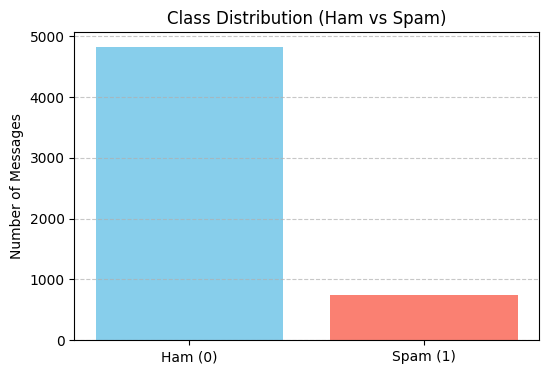

In [ ]:
df['message_length'] = df['message'].apply(len)

# Class distribution
plt.figure(figsize=(6, 4))
class_counts = df['label'].value_counts()
plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'salmon'])
plt.title('Class Distribution (Ham vs Spam)')
plt.xticks([0,1], ['Ham (0)', 'Spam (1)'])
plt.ylabel("Number of Messages")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

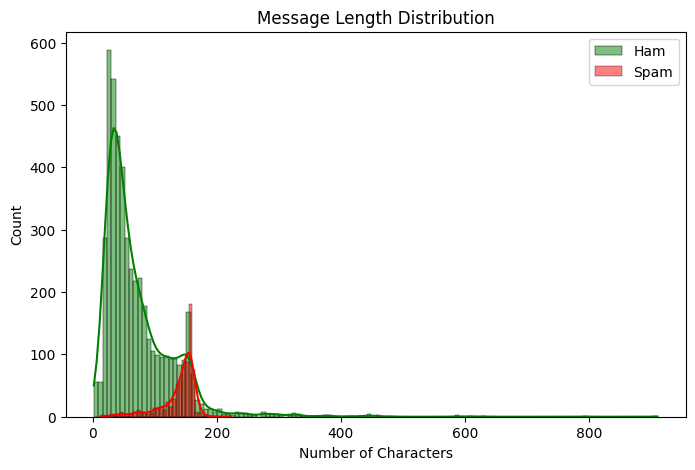

In [ ]:
# Message length distribution
plt.figure(figsize=(8,5))
sns.histplot(df[df['label']==0]['message_length'], color='green', label='Ham', kde=True)
sns.histplot(df[df['label']==1]['message_length'], color='red', label='Spam', kde=True)
plt.legend()
plt.title("Message Length Distribution")
plt.xlabel("Number of Characters")
plt.show()


/tmp/ipython-input-905822834.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='message_length', data=df, palette=['green', 'red'])


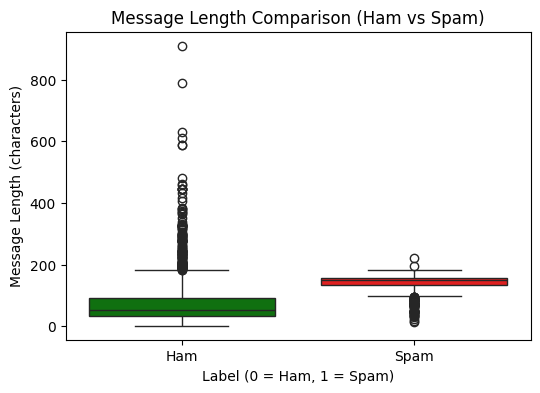

In [ ]:
# 📦 Boxplot to compare message lengths between ham and spam
# Helps visualize median, spread, and outliers clearly

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.boxplot(x='label', y='message_length', data=df, palette=['green', 'red'])
plt.title('Message Length Comparison (Ham vs Spam)')
plt.xlabel('Label (0 = Ham, 1 = Spam)')
plt.ylabel('Message Length (characters)')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.show()


In [ ]:
# Average and max message lengths
avg_lengths = df.groupby('label')['message_length'].mean()
max_lengths = df.groupby('label')['message_length'].max()
print("Average Message Lengths:\n", avg_lengths)
print("\nMax Message Lengths:\n", max_lengths)

# Count of ham messages longer than 800 characters
long_ham_count = df[(df['label'] == 0) & (df['message_length'] > 200)].shape[0]
print(f"\nNumber of ham messages longer than 200 characters: {long_ham_count}")


Average Message Lengths:
 label
0     71.482487
1    138.670683
Name: message_length, dtype: float64

Max Message Lengths:
 label
0    910
1    223
Name: message_length, dtype: int64

Number of ham messages longer than 200 characters: 112


In [ ]:
count_above_800 = df[df['message_length'] > 800].shape[0]
print(f"Number of messages longer than 800 characters: {count_above_800}")

Number of messages longer than 800 characters: 1


Visualize most frequent words in ham vs spam messages to explore patterns in text data


In [ ]:
# 5️⃣ WordCloud for Ham and Spam messages
ham_text = " ".join(df[df['label']==0]['message'])
spam_text = " ".join(df[df['label']==1]['message'])

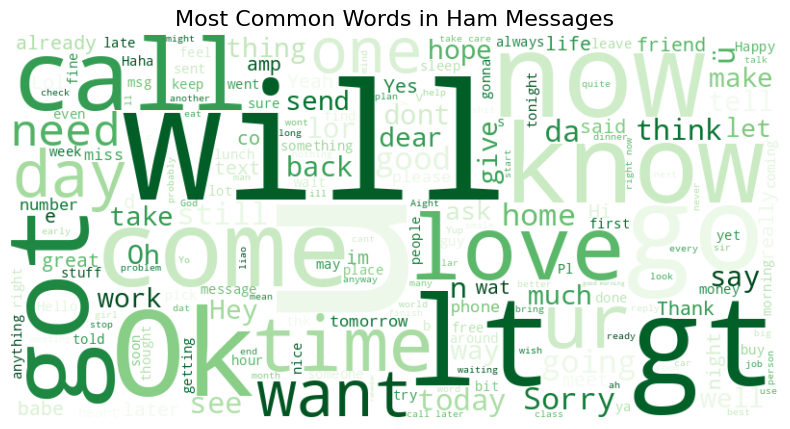

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Ham WordCloud
plt.figure(figsize=(10,5))
ham_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(ham_text)
plt.imshow(ham_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Ham Messages", fontsize=16)
plt.show()

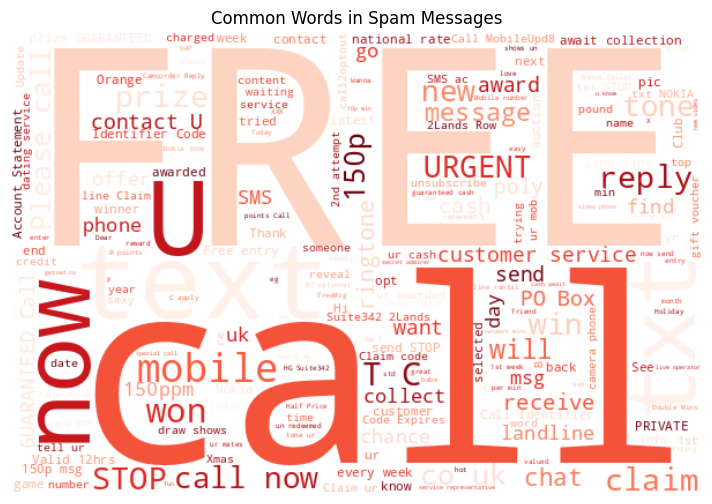

In [ ]:
# Spam WordCloud
wc_spam = WordCloud(width=600, height=400, background_color='white', colormap='Reds').generate(spam_text)
plt.figure(figsize=(10,6))
plt.imshow(wc_spam, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Spam Messages")
plt.show()

Text Cleaning : Lowercase all messages and remove special characters

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

df['clean_message'] = df['message'].apply(clean_text)
df.head()

,label,message,message_length,clean_message
0,0,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah i dont think he goes to usf he lives aroun...


Define Features and Labels

In [ ]:
X_text = df['clean_message']          # cleaned text
X_length = df[['message_length']]     # numeric message length
y = df['label']                       # target variable

Train-Test Split

In [ ]:
# Stratified split to keep spam/ham ratio
X_text_train, X_text_test, X_length_train, X_length_test, y_train, y_test = train_test_split(
    X_text, X_length, y, test_size=0.2, random_state=42, stratify=y
)


Convert Text to Numerical Form (TF-IDF)

In [ ]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_text_train_tfidf = vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = vectorizer.transform(X_text_test)

Scale Message Length

In [ ]:
scaler_minmax = MinMaxScaler()

# MinMax scaling
X_length_train_minmax = scaler_minmax.fit_transform(X_length_train)
X_length_test_minmax = scaler_minmax.transform(X_length_test)

# Standard scaling
X_length_train_std = scaler_minmax.fit_transform(X_length_train)
X_length_test_std = scaler_minmax.transform(X_length_test)

Create final datasets for Naive Bayes (MinMax) and Logistic Regression (StandardScaler)

In [ ]:
# Combine Text + Numeric Features

# Naive Bayes features
X_train_nb = hstack([X_text_train_tfidf, X_length_train_minmax])
X_test_nb = hstack([X_text_test_tfidf, X_length_test_minmax])

# Logistic Regression features
X_train_lr = hstack([X_text_train_tfidf, X_length_train_std])
X_test_lr = hstack([X_text_test_tfidf, X_length_test_std])

Training and Evaluation without Class Imbalancing Handling

In [ ]:
# Train Naive Bayes Variants (No Balancing)

# Import models and metrics
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB, GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Dictionary to store models and results
nb_models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "GaussianNB": GaussianNB() # GaussianNB requires dense data
}

nb_results = {}

# Train & evaluate each model
for name, model in nb_models.items():
    if name == "GaussianNB":
        # Convert sparse data to dense for GaussianNB
        model.fit(X_train_nb.toarray(), y_train)
    else:
        model.fit(X_train_nb, y_train)  # X_train_nb uses MinMax scaling (sparse)

    y_pred = model.predict(X_test_nb.toarray() if name == "GaussianNB" else X_test_nb) # Convert test data to dense for GaussianNB as well
    report = classification_report(y_test, y_pred, output_dict=True)
    nb_results[name] = report
    print(f"\n🔹 {name} Classification Report:\n")
    print(classification_report(y_test, y_pred))


🔹 MultinomialNB Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115


🔹 BernoulliNB Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       0.99      0.83      0.91       149

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115


🔹 ComplementNB Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       966
           1       0.77      0.93      0.84       149

    accuracy                           0.95      1115
   macro

In [ ]:
# 📌 CELL 10: Compare Metrics Across Naive Bayes Models
# Extract precision, recall, f1-score for Spam class for each NB variant

metrics_list = []

for model_name, report in nb_results.items():
    metrics_list.append({
        "Model": model_name,
        "Precision": report['1']['precision'],  # spam class
        "Recall": report['1']['recall'],
        "F1-Score": report['1']['f1-score']
    })

metrics_df = pd.DataFrame(metrics_list)

metrics_df

,Model,Precision,Recall,F1-Score
0,MultinomialNB,1.000000,0.791946,0.883895
1,BernoulliNB,0.992000,0.832215,0.905109
2,ComplementNB,0.770950,0.926174,0.841463
3,GaussianNB,0.458621,0.892617,0.605923


BernoulliNB: Precision very high (0.99) and recall better (0.83) → slightly more balanced.

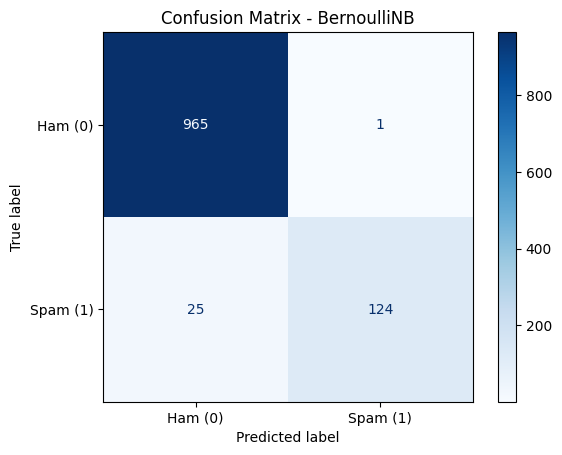

In [ ]:
# ====================================================
# 10️⃣ Display Confusion Matrix for Selected Naive Bayes Model (BernoulliNB)
# ====================================================

from sklearn.metrics import ConfusionMatrixDisplay

# BernoulliNB was selected as the optimal Naive Bayes model
optimal_nb_model = BernoulliNB()
optimal_nb_model.fit(X_train_nb, y_train)
y_pred_nb = optimal_nb_model.predict(X_test_nb)

# Display confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    optimal_nb_model,
    X_test_nb,
    y_test,
    display_labels=['Ham (0)', 'Spam (1)'],
    cmap=plt.cm.Blues,
    normalize=None
)
plt.title("Confusion Matrix - BernoulliNB")
plt.show()


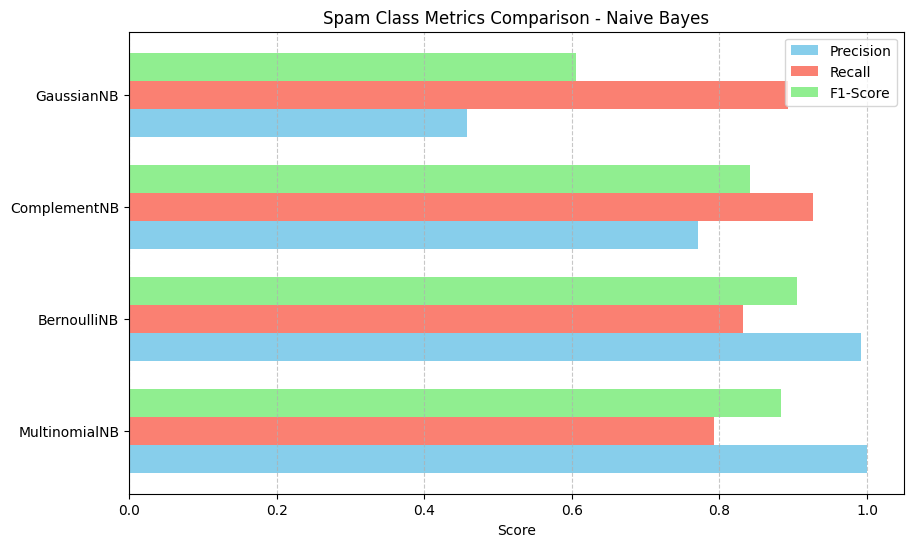

In [ ]:
# 📌 CELL 11: Plot Spam Metrics Comparison for Naive Bayes
# Horizontal bar graph for precision, recall, f1-score of spam class

plt.figure(figsize=(10,6))
bar_width = 0.25
x = np.arange(len(metrics_df['Model']))

plt.barh(x - bar_width, metrics_df['Precision'], height=bar_width, label='Precision', color='skyblue')
plt.barh(x, metrics_df['Recall'], height=bar_width, label='Recall', color='salmon')
plt.barh(x + bar_width, metrics_df['F1-Score'], height=bar_width, label='F1-Score', color='lightgreen')

plt.yticks(x, metrics_df['Model'])
plt.xlabel("Score")
plt.title("Spam Class Metrics Comparison - Naive Bayes")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Train Logistic Regression for Comparison

In [ ]:
# ====================================================
#  Train Logistic Regression using the same features
# ====================================================

from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_nb, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test_nb)
from sklearn.metrics import classification_report
print("🔹 Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr))


🔹 Logistic Regression Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.97      0.79      0.87       149

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



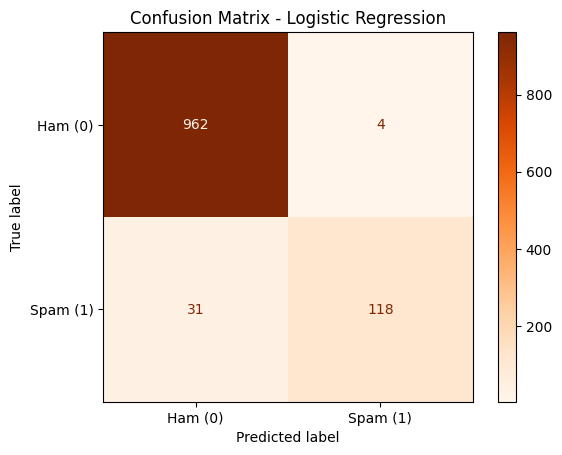

In [ ]:
# ====================================================
# 14️⃣ Display Confusion Matrix for Logistic Regression
# ====================================================

from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix for LR
disp_lr = ConfusionMatrixDisplay.from_estimator(
    lr_model,
    X_test_nb,
    y_test,
    display_labels=['Ham (0)', 'Spam (1)'],
    cmap=plt.cm.Oranges,
    normalize=None
)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [ ]:
# ====================================================
# 12️⃣ Compare BernoulliNB vs Logistic Regression Metrics
# ====================================================

import pandas as pd
import matplotlib.pyplot as plt

# Collect metrics
metrics_df = pd.DataFrame({
    'Model': ['BernoulliNB', 'LogisticRegression'],
    'Precision': [classification_report(y_test, y_pred_nb, output_dict=True)['1']['precision'],
                  classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision']],
    'Recall': [classification_report(y_test, y_pred_nb, output_dict=True)['1']['recall'],
               classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall']],
    'F1-Score': [classification_report(y_test, y_pred_nb, output_dict=True)['1']['f1-score'],
                 classification_report(y_test, y_pred_lr, output_dict=True)['1']['f1-score']]
})

metrics_df

,Model,Precision,Recall,F1-Score
0,BernoulliNB,0.992000,0.832215,0.905109
1,LogisticRegression,0.967213,0.791946,0.870849


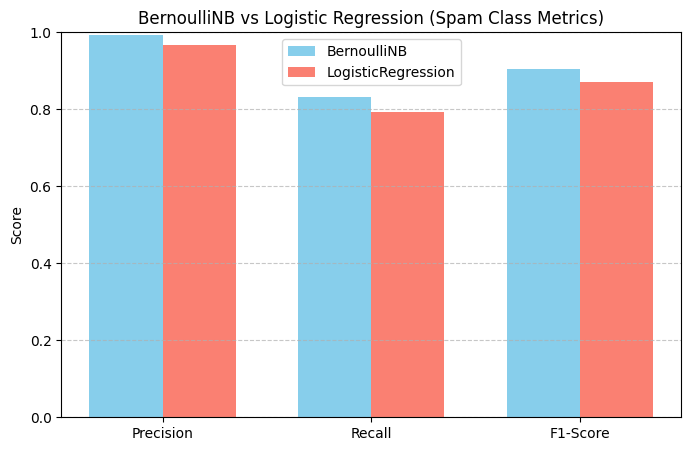

In [ ]:
# ====================================================
# 13️⃣ Plot Comparison Bar Graph for BernoulliNB vs Logistic Regression
# ====================================================

metrics = ['Precision', 'Recall', 'F1-Score']
x = range(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar([p - width/2 for p in x], metrics_df.loc[0, metrics], width=width, label='BernoulliNB', color='skyblue')
plt.bar([p + width/2 for p in x], metrics_df.loc[1, metrics], width=width, label='LogisticRegression', color='salmon')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('BernoulliNB vs Logistic Regression (Spam Class Metrics)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Handling Class Imbalance using SMOTE to Improve Spam Recall
We apply SMOTE on the training data to synthetically generate spam samples. This helps increase spam recall while maintaining high precision. We will train BernoulliNB and Logistic Regression on the balanced dataset and evaluate.


In [ ]:
# Import SMOTE
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_nb, y_train)

print("Before SMOTE class distribution:\n", y_train.value_counts())
print("\nAfter SMOTE class distribution:\n", pd.Series(y_train_smote).value_counts())

Before SMOTE class distribution:
 label
0    3859
1     598
Name: count, dtype: int64

After SMOTE class distribution:
 label
0    3859
1    3859
Name: count, dtype: int64


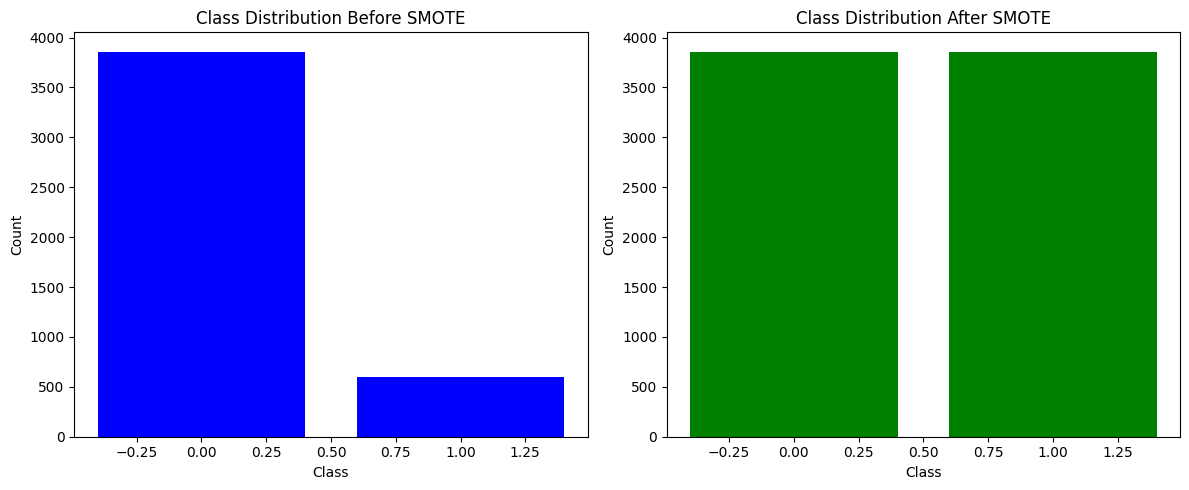

In [ ]:
import matplotlib.pyplot as plt

# Class distribution before SMOTE
counts_before = y_train.value_counts()
# Class distribution after SMOTE
counts_after = pd.Series(y_train_smote).value_counts()

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
axes[0].bar(counts_before.index, counts_before.values, color='blue')
axes[0].set_title('Class Distribution Before SMOTE')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# After SMOTE
axes[1].bar(counts_after.index, counts_after.values, color='green')
axes[1].set_title('Class Distribution After SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


We now train BernoulliNB and Logistic Regression on the SMOTE-balanced training set. This helps improve recall for the minority class (Spam) without hurting precision significantly.

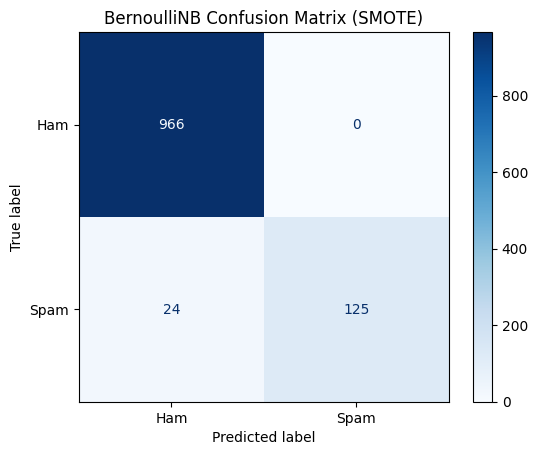

In [ ]:
# ===== Train BernoulliNB on SMOTE data =====
nb_smote = BernoulliNB()
nb_smote.fit(X_train_smote, y_train_smote)
y_pred_nb = nb_smote.predict(X_test_nb)

# Confusion matrix for BernoulliNB
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(cm_nb, display_labels=['Ham','Spam'])
disp_nb.plot(cmap=plt.cm.Blues)
plt.title("BernoulliNB Confusion Matrix (SMOTE)")
plt.show()

In [ ]:
print("\n🔹 BernoulliNB Classification Report (SMOTE):\n")
print(classification_report(y_test, y_pred_nb))


🔹 BernoulliNB Classification Report (SMOTE):

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



Train on Logistic Regression Model

In [ ]:
# ===== Train Logistic Regression on SMOTE data =====
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_train_smote, y_train_smote)
y_pred_lr = lr_smote.predict(X_test_lr)

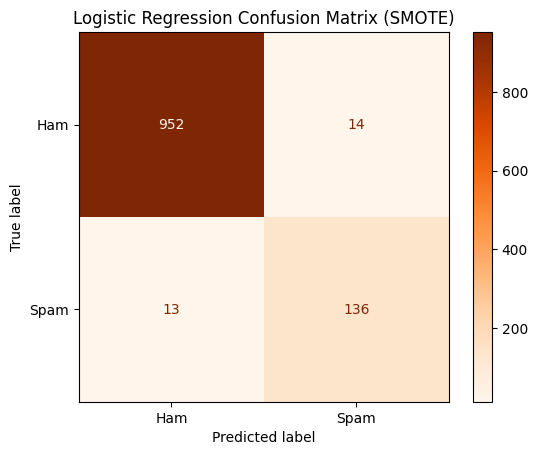

In [ ]:
# Confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['Ham','Spam'])
disp_lr.plot(cmap=plt.cm.Oranges)
plt.title("Logistic Regression Confusion Matrix (SMOTE)")
plt.show()

In [ ]:
print("\n🔹 Logistic Regression Classification Report (SMOTE):\n")
print(classification_report(y_test, y_pred_lr))


🔹 Logistic Regression Classification Report (SMOTE):

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.91      0.91      0.91       149

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115



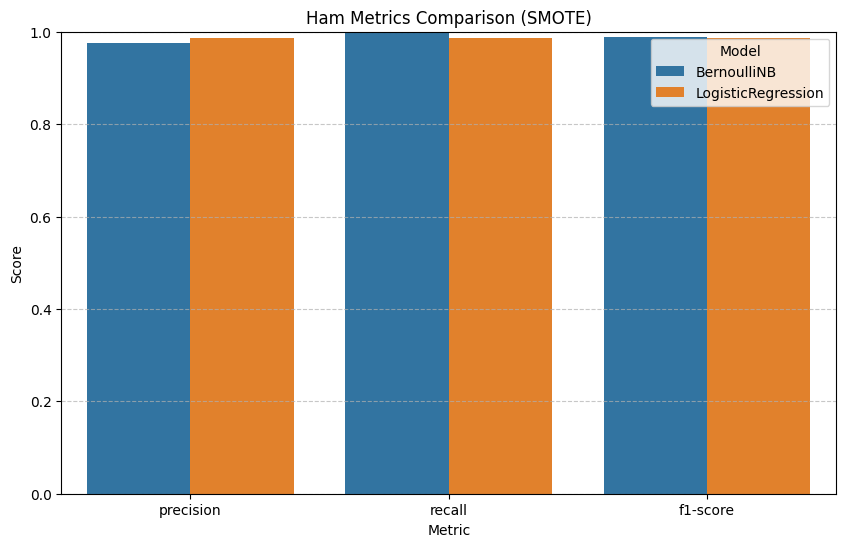

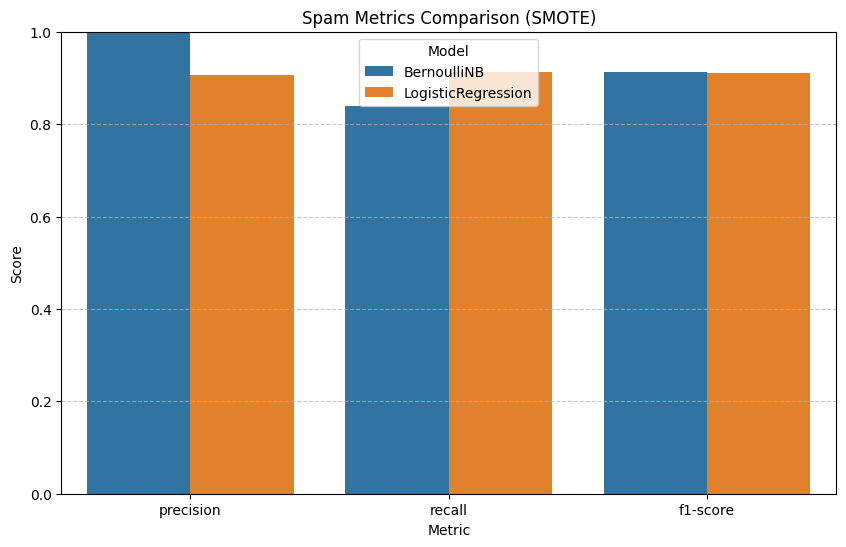

In [ ]:
# ===== Comparison Bar Charts for Ham and Spam =====
metrics = ['precision', 'recall', 'f1-score']
models = ['BernoulliNB', 'LogisticRegression']

def collect_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    # Use numerical keys '0' for ham and '1' for spam
    return [report['0'][m] for m in metrics], [report['1'][m] for m in metrics]

ham_nb_metrics, spam_nb_metrics = collect_metrics(y_test, y_pred_nb)
ham_lr_metrics, spam_lr_metrics = collect_metrics(y_test, y_pred_lr)

# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'Metric': metrics * len(models) * 2, # 3 metrics * 2 models * 2 classes = 12
    'Score': ham_nb_metrics + ham_lr_metrics + spam_nb_metrics + spam_lr_metrics,
    'Model': ['BernoulliNB'] * len(metrics) + ['LogisticRegression'] * len(metrics) + ['BernoulliNB'] * len(metrics) + ['LogisticRegression'] * len(metrics), # 3 for each model for ham, then 3 for each for spam
    'Class': ['Ham'] * (len(metrics) * len(models)) + ['Spam'] * (len(metrics) * len(models)) # 6 for ham, 6 for spam
})

import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_plot[df_plot['Class']=='Ham'])
plt.ylim(0,1)
plt.title("Ham Metrics Comparison (SMOTE)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_plot[df_plot['Class']=='Spam'])
plt.ylim(0,1)
plt.title("Spam Metrics Comparison (SMOTE)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [40]:
import joblib
from sklearn.preprocessing import MinMaxScaler

# Assuming you already have:
# nb_smote -> trained BernoulliNB model
# lr_smote -> trained LogisticRegression model
# vectorizer -> trained TfidfVectorizer
# scaler_minmax -> fitted MinMaxScaler for message_length feature

# Define save paths
nb_smote_path = "/content/drive/MyDrive/Mtech/Machine Learning Project/models/bernoulli_nb_smote-combinedtdf.pkl"
lr_smote_path = "/content/drive/MyDrive/Mtech/Machine Learning Project/models/logistic_regression_smote-combinedtdf.pkl"

# Save model + vectorizer + scaler together
joblib.dump((nb_smote, vectorizer, scaler_minmax), nb_smote_path)
joblib.dump((lr_smote, vectorizer, scaler_minmax), lr_smote_path)

print("✅ Models + Vectorizer + Scaler saved successfully to Drive:")
print(f"BernoulliNB -> {nb_smote_path}")
print(f"Logistic Regression -> {lr_smote_path}")

✅ Models + Vectorizer + Scaler saved successfully to Drive:
BernoulliNB -> /content/drive/MyDrive/Mtech/Machine Learning Project/models/bernoulli_nb_smote-combinedtdf.pkl
Logistic Regression -> /content/drive/MyDrive/Mtech/Machine Learning Project/models/logistic_regression_smote-combinedtdf.pkl
